Bu projenin amacı 5 saatlik enerji tahmini yapabilmektir.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_csv('../input/hourly-energy-consumption/PJM_Load_hourly.csv', index_col=[0], parse_dates=[0])

Veri kontrolü yapıyorum

In [3]:
df.isnull().sum()

PJM_Load_MW    0
dtype: int64

In [4]:
df.head(5)

,PJM_Load_MW
Datetime,
1998-12-31 01:00:00,29309.0
1998-12-31 02:00:00,28236.0
1998-12-31 03:00:00,27692.0
1998-12-31 04:00:00,27596.0
1998-12-31 05:00:00,27888.0


ANALİZ
Örneğin; belirli günlerde(iş günlerinde) ve zaman aralıklarında(kış mevsimi) kullanım farkı olması.

Saatlik olan frekans yeniden örneklendirme ile günlük hale getirilecek.

In [5]:
daily_data = df.resample(rule='D').sum()

daily_data = daily_data.asfreq('D')

daily_data.head(10)

,PJM_Load_MW
Datetime,
1998-04-01,639716.0
1998-04-02,638539.0
1998-04-03,616136.0
1998-04-04,587690.0
1998-04-05,540214.0
1998-04-06,640312.0
1998-04-07,643340.0
1998-04-08,636976.0
1998-04-09,657606.0


In [6]:
daily_data.index

DatetimeIndex(['1998-04-01', '1998-04-02', '1998-04-03', '1998-04-04',
               '1998-04-05', '1998-04-06', '1998-04-07', '1998-04-08',
               '1998-04-09', '1998-04-10',
               ...
               '2001-12-23', '2001-12-24', '2001-12-25', '2001-12-26',
               '2001-12-27', '2001-12-28', '2001-12-29', '2001-12-30',
               '2001-12-31', '2002-01-01'],
              dtype='datetime64[ns]', name='Datetime', length=1372, freq='D')

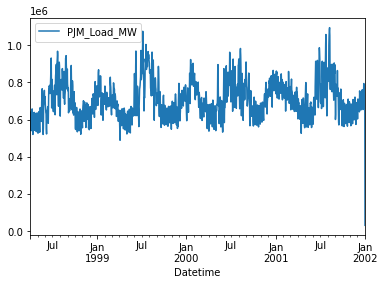

In [7]:
daily_data.plot()

plt.show()

Now there's a tail end where it's not a full day, so it's dropping off.

For our purposes, we will just delete that part day.

In [8]:
daily_data = daily_data.drop([daily_data.index.min(), daily_data.index.max()])

As you can see the graph is now neat.

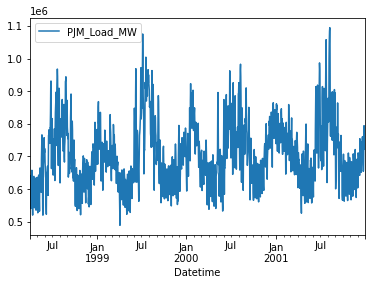

In [9]:
daily_data.plot()

plt.show()

Mevsimsel ayrıştırma yapıyorum.



Figure(432x288)


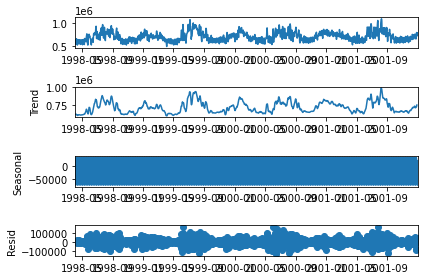

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter
decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()

print(fig)



plt.show()

Haftalık seviyeye getirerek gürültüyü azaltacağım.

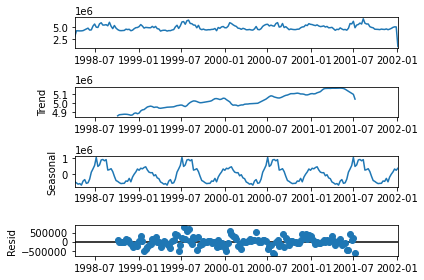

In [11]:

weekly_data = df.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive') 

fig = decomposition.plot()
plt.show()

Elektrik kullanımını günlük kıyas olarak görebilmek için haftaya dayandıracağım.

In [12]:
print(daily_data)

            PJM_Load_MW
Datetime               
1998-04-02     638539.0
1998-04-03     616136.0
1998-04-04     587690.0
1998-04-05     540214.0
1998-04-06     640312.0
...                 ...
2001-12-27     794222.0
2001-12-28     779757.0
2001-12-29     721638.0
2001-12-30     743012.0
2001-12-31     782528.0

[1370 rows x 1 columns]


In [13]:
heatmap_data = daily_data.copy()

heatmap_data['Weekday_Name'] = daily_data.index.day_name()

heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()
 
heatmap_data = heatmap_data.reset_index()

heatmap_data = heatmap_data[heatmap_data['Year'] != 1998]
heatmap_data = heatmap_data[heatmap_data['Year'] != 2002]

heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='PJM_Load_MW')

heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head()

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
1999,38092135.0,38774129.0,38516979.0,37965959.0,38300748.0,34520449.0,33434778.0
2000,38416086.0,39004068.0,39083248.0,38801343.0,38697257.0,35938239.0,34523833.0
2001,39346716.0,39513252.0,39569076.0,39546228.0,38758308.0,34952537.0,33667690.0


Text(0.5, 1.0, 'Heatmap - by Day of Week')

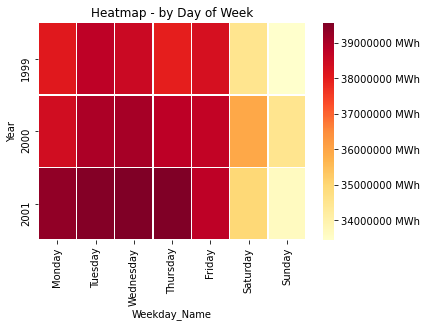

In [14]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Week')

In [15]:
heatmap_data = df.copy()

heatmap_data['Hour'] = df.index.hour

heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()
 
heatmap_data = heatmap_data.reset_index()

heatmap_data = heatmap_data[heatmap_data['Year'] != 1998]
heatmap_data = heatmap_data[heatmap_data['Year'] != 2002]

heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='PJM_Load_MW')

heatmap_data.head(100)

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,
1999,9943437.0,9188610.0,8744167.0,8535105.0,8452873.0,8537766.0,9009618.0,9926724.0,10697629.0,11168242.0,...,11853079.0,11802746.0,11782744.0,11923339.0,12210668.0,12237325.0,12112759.0,12026547.0,11671503.0,10849426.0
2000,10157201.0,9402403.0,8955261.0,8737767.0,8662359.0,8755669.0,9232708.0,10150397.0,10927040.0,11405389.0,...,12021257.0,11973195.0,11948742.0,12084552.0,12380480.0,12432455.0,12333560.0,12244055.0,11881815.0,11058985.0
2001,10151442.0,9402676.0,8949210.0,8719579.0,8639831.0,8735126.0,9216468.0,10137226.0,10912751.0,11398506.0,...,12117027.0,12072650.0,12052017.0,12190374.0,12484562.0,12523344.0,12402059.0,12320561.0,11933403.0,11072587.0


Text(0.5, 1.0, 'Heatmap - by Hour of Day')

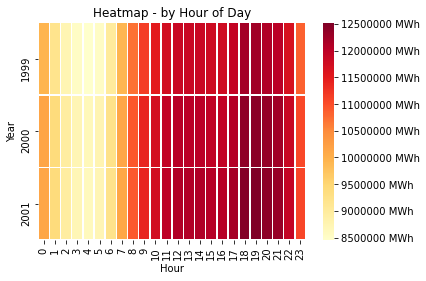

In [16]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Hour of Day')

Yıllık periyot olarakta bakalım.

In [17]:
heatmap_data = daily_data.copy()

heatmap_data['Month'] = daily_data.index.month_name()

heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

heatmap_data = heatmap_data.reset_index()

heatmap_data = heatmap_data[heatmap_data['Year'] != 2002]

heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='PJM_Load_MW')

heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
1998,NaN,NaN,NaN,17618486.0,19914613.0,21413823.0,24449999.0,24685281.0,21446221.0,19094647.0,19145916.0,21333067.0
1999,22901603.0,19989436.0,21448620.0,18416083.0,19243349.0,22707744.0,27487675.0,24908011.0,20981847.0,19648508.0,19600795.0,22271506.0
2000,24061729.0,21501663.0,20759960.0,18969551.0,20711085.0,23472915.0,23660398.0,24498907.0,21368483.0,20156640.0,20720606.0,24582137.0
2001,24335585.0,20886586.0,22292885.0,19407746.0,20434869.0,23710239.0,24317498.0,27128576.0,20971032.0,20318878.0,19585025.0,21964888.0


Text(0.5, 1.0, 'Heatmap - by Day of Month')

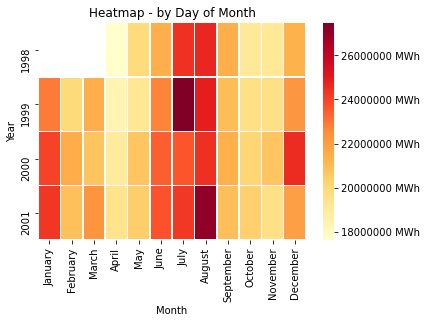

In [18]:
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f MWh'}).set_title('Heatmap - by Day of Month')

Now let us start with building our models and testing which models is the best.

Models that we are testing:
1. XGBoost
2. RNN
3. LSTM

Şimdi de modeller oluşturup test ederek en iyisini bulalım.


Kullanılan modeller;

1. XGBoost
2. RNN
3. LSTM

# **XGBoost**

XGBOOST için normalleştirme gerekli değildir. 

Çünkü; Karar Ağaçları, girdilerinin normalleştirilmesini gerektirmez; ve XGBoost, esasen Karar Ağaçlarından oluşan bir topluluk algoritması olduğundan, girişler için normalleştirme de gerektirmez.

**Eğitim ve Test**

In [19]:
split_date = '31-Dec-2000'
df_train = df.loc[df.index <= split_date].copy() 
df_test = df.loc[df.index > split_date].copy() 

In [20]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)


(32896, 1)
(24114, 1)
(8782, 1)


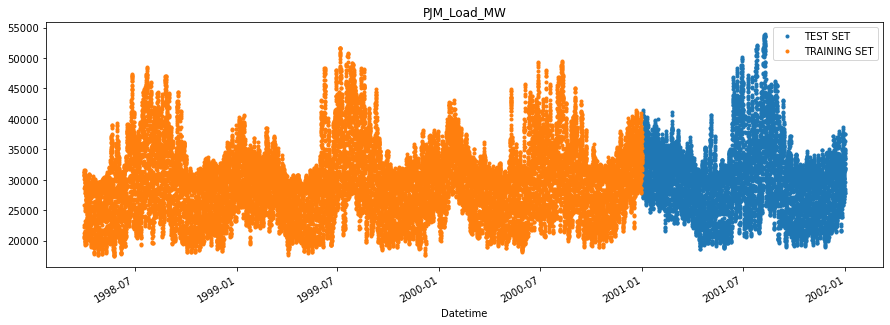

In [21]:
_ = df_test \
    .rename(columns={'PJM_Load_MW': 'TEST SET'}) \
    .join(df_train.rename(columns={'PJM_Load_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM_Load_MW', style='.')

Bazı zaman serisi özellikleri oluşturmamız lazım.

In [22]:
def create_features(df, label=None):
    
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [23]:
X_train, y_train = create_features(df_train, label='PJM_Load_MW') 
X_test, y_test = create_features(df_test, label='PJM_Load_MW')

In [24]:
X_train.head(5)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
1998-12-31 01:00:00,1,3,4,12,1998,365,31,53
1998-12-31 02:00:00,2,3,4,12,1998,365,31,53
1998-12-31 03:00:00,3,3,4,12,1998,365,31,53
1998-12-31 04:00:00,4,3,4,12,1998,365,31,53
1998-12-31 05:00:00,5,3,4,12,1998,365,31,53


In [25]:
y_train.head(5)

Datetime
1998-12-31 01:00:00    29309.0
1998-12-31 02:00:00    28236.0
1998-12-31 03:00:00    27692.0
1998-12-31 04:00:00    27596.0
1998-12-31 05:00:00    27888.0
Name: PJM_Load_MW, dtype: float64

XGBoost modeli oluşturma

In [26]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

output = reg.predict(X_test)

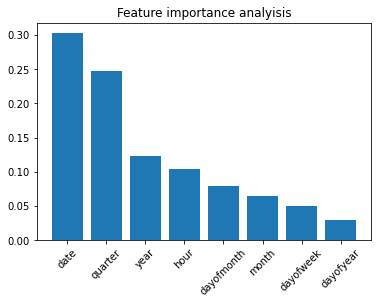

In [27]:
features = ["date", "hour", "dayofweek", "quarter", "month", "year", "dayofyear", "dayofmonth", "weekofyear"]

importances = reg.feature_importances_

sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))
 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
plt.xticks(rotation=45)
plt.show()

Modeli kullanarak tahminde bulunalım.

In [28]:
df_test['MW_Prediction'] =reg.predict(X_test)
 
PJM_all = pd.concat([df_test, df_train], sort=False)

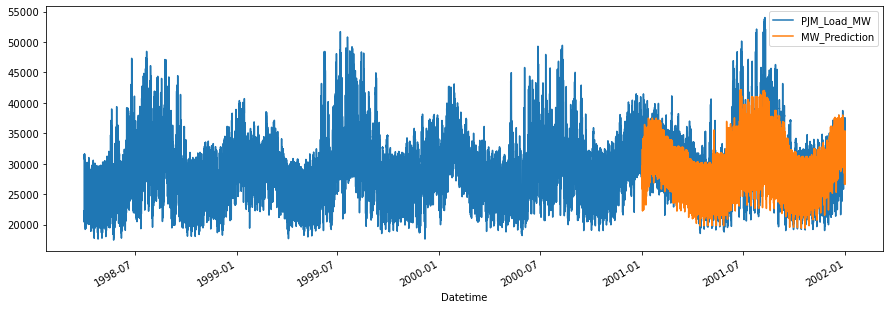

In [29]:
_ = PJM_all[['PJM_Load_MW','MW_Prediction']].plot(figsize=(15, 5))

Hata Matrisi Kullanılan farklı hata matrisi türleri:

* R^2 (korelasyon puanı)
* Ortalama Kare Hatası
* Ortalama Mutlak Hata

XGBoost için sonuçlar:

* R ^ 2 XGBoost modelinin puanı = 0,7400406595803339
* Ortalama Kare Hatası = 8943038.068857703
* Ortalama Mutlak Hata = 2169.8273519343543



In [30]:
from sklearn.metrics import r2_score

In [31]:
lstm_score = r2_score(y_test, output)
print("R^2 Score of XGBoost model = ",lstm_score)

R^2 Score of XGBoost model =  0.7400406595803339


In [32]:
mean_squared_error = mean_squared_error(y_true=df_test['PJM_Load_MW'],
                   y_pred=df_test['MW_Prediction'])
print("Mean_squared_error =", mean_squared_error)

Mean_squared_error = 8943038.068857703


In [33]:
mean_absolute_error = mean_absolute_error(y_true=df_test['PJM_Load_MW'],
                   y_pred=df_test['MW_Prediction'])
print("Mean_absolute_error =", mean_absolute_error)

Mean_absolute_error = 2169.8273519343543


In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error = mean_absolute_percentage_error(y_true=df_test['PJM_Load_MW'],
                   y_pred=df_test['MW_Prediction'])

print("Mean_absolute_error = " + str(mean_absolute_percentage_error) + " %")


Mean_absolute_error = 6.948508186270928 %


# **XGBoost için başka bir yöntem**

Özellik mühendisliği

In [35]:
def preprocess_xgb_data(df, lag_start=1, lag_end=365):
    
    for i in range(lag_start,lag_end):
        df[f'PJM_Load_MW {i}'] = df.shift(periods=i, freq='D')['PJM_Load_MW']

    df.reset_index(inplace=True)

    df['date_epoch'] = pd.to_numeric(df['Datetime']) 
    df['hour'] = df['Datetime'].dt.hour
    df['dayofweek'] = df['Datetime'].dt.dayofweek
    df['dayofmonth'] = df['Datetime'].dt.day
    df['dayofyear'] = df['Datetime'].dt.dayofyear
    df['weekofyear'] = df['Datetime'].dt.weekofyear
    df['quarter'] = df['Datetime'].dt.quarter
    df['month'] = df['Datetime'].dt.month
    df['year'] = df['Datetime'].dt.year
    
    x = df.drop(columns=['Datetime', 'PJM_Load_MW']) 
    y = df['PJM_Load_MW'] 
    
    return x, y

In [36]:
cutoff = '2000-12-31'

daily_data.sort_index()

train = daily_data[:cutoff]
test = daily_data[cutoff:]

In [37]:
example_data = train.copy() 

example_x, example_y = preprocess_xgb_data(example_data)

example_x.head(10)

,PJM_Load_MW 1,PJM_Load_MW 2,PJM_Load_MW 3,PJM_Load_MW 4,PJM_Load_MW 5,PJM_Load_MW 6,PJM_Load_MW 7,PJM_Load_MW 8,PJM_Load_MW 9,PJM_Load_MW 10,...,PJM_Load_MW 364,date_epoch,hour,dayofweek,dayofmonth,dayofyear,weekofyear,quarter,month,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,891475200000000000,0,3,2,92,14,2,4,1998
1,638539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,891561600000000000,0,4,3,93,14,2,4,1998
2,616136.0,638539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,891648000000000000,0,5,4,94,14,2,4,1998
3,587690.0,616136.0,638539.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,891734400000000000,0,6,5,95,14,2,4,1998
4,540214.0,587690.0,616136.0,638539.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,891820800000000000,0,0,6,96,15,2,4,1998
5,640312.0,540214.0,587690.0,616136.0,638539.0,NaN,NaN,NaN,NaN,NaN,...,NaN,891907200000000000,0,1,7,97,15,2,4,1998
6,643340.0,640312.0,540214.0,587690.0,616136.0,638539.0,NaN,NaN,NaN,NaN,...,NaN,891993600000000000,0,2,8,98,15,2,4,1998
7,636976.0,643340.0,640312.0,540214.0,587690.0,616136.0,638539.0,NaN,NaN,NaN,...,NaN,892080000000000000,0,3,9,99,15,2,4,1998
8,657606.0,636976.0,643340.0,640312.0,540214.0,587690.0,616136.0,638539.0,NaN,NaN,...,NaN,892166400000000000,0,4,10,100,15,2,4,1998
9,601388.0,657606.0,636976.0,643340.0,640312.0,540214.0,587690.0,616136.0,638539.0,NaN,...,NaN,892252800000000000,0,5,11,101,15,2,4,1998


In [38]:
xtrain = train.copy() 
xtest = test.copy() 

train_feature, train_label = preprocess_xgb_data(xtrain)
test_feature, test_label = preprocess_xgb_data(xtest)

test_feature.head(10)

,PJM_Load_MW 1,PJM_Load_MW 2,PJM_Load_MW 3,PJM_Load_MW 4,PJM_Load_MW 5,PJM_Load_MW 6,PJM_Load_MW 7,PJM_Load_MW 8,PJM_Load_MW 9,PJM_Load_MW 10,...,PJM_Load_MW 364,date_epoch,hour,dayofweek,dayofmonth,dayofyear,weekofyear,quarter,month,year
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,978220800000000000,0,6,31,366,52,4,12,2000
1,755509.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,978307200000000000,0,0,1,1,1,1,1,2001
2,739250.0,755509.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,978393600000000000,0,1,2,2,1,1,1,2001
3,835115.0,739250.0,755509.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,978480000000000000,0,2,3,3,1,1,1,2001
4,861307.0,835115.0,739250.0,755509.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,978566400000000000,0,3,4,4,1,1,1,2001
5,844504.0,861307.0,835115.0,739250.0,755509.0,NaN,NaN,NaN,NaN,NaN,...,NaN,978652800000000000,0,4,5,5,1,1,1,2001
6,856184.0,844504.0,861307.0,835115.0,739250.0,755509.0,NaN,NaN,NaN,NaN,...,NaN,978739200000000000,0,5,6,6,1,1,1,2001
7,753527.0,856184.0,844504.0,861307.0,835115.0,739250.0,755509.0,NaN,NaN,NaN,...,NaN,978825600000000000,0,6,7,7,1,1,1,2001
8,715963.0,753527.0,856184.0,844504.0,861307.0,835115.0,739250.0,755509.0,NaN,NaN,...,NaN,978912000000000000,0,0,8,8,2,1,1,2001
9,798327.0,715963.0,753527.0,856184.0,844504.0,861307.0,835115.0,739250.0,755509.0,NaN,...,NaN,978998400000000000,0,1,9,9,2,1,1,2001


In [39]:

from xgboost import XGBRegressor
from sklearn.model_selection import KFold, train_test_split

model = XGBRegressor(
    max_depth=6
    ,n_estimators=1000
    ,booster='gbtree'
    ,colsample_bytree=1 
    ,eta=0.3 
    ,importance_type='weight' 
)
model.fit(
    train_feature
    ,train_label
    ,eval_set=[(train_feature, train_label)]
    ,eval_metric='mae'
    ,verbose=True
    ,early_stopping_rounds=100 
)

xtest['PJM_Load_MW Prediction'] = model.predict(test_feature)
XGB_prediction = xtest[['Datetime', 'PJM_Load_MW Prediction']]



[0]	validation_0-mae:497590.43750
Will train until validation_0-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:348903.50000
[2]	validation_0-mae:244993.90625
[3]	validation_0-mae:172217.34375
[4]	validation_0-mae:121468.93750
[5]	validation_0-mae:85815.03125
[6]	validation_0-mae:60810.62500
[7]	validation_0-mae:43257.45703
[8]	validation_0-mae:31384.62305
[9]	validation_0-mae:23775.93164
[10]	validation_0-mae:18706.64453
[11]	validation_0-mae:15111.72559
[12]	validation_0-mae:13095.98242
[13]	validation_0-mae:11884.46777
[14]	validation_0-mae:10861.52539
[15]	validation_0-mae:10249.40527
[16]	validation_0-mae:9537.03711
[17]	validation_0-mae:9285.36328
[18]	validation_0-mae:8752.82422
[19]	validation_0-mae:8497.34375
[20]	validation_0-mae:8183.97314
[21]	validation_0-mae:8037.02393
[22]	validation_0-mae:7871.42480
[23]	validation_0-mae:7526.26562
[24]	validation_0-mae:7308.14746
[25]	validation_0-mae:7106.11621
[26]	validation_0-mae:6691.13721
[27]	validation_0-mae:6570.83203


In [40]:
XGB_prediction.head()

,Datetime,PJM_Load_MW Prediction
0,2000-12-31,617040.0625
1,2001-01-01,730434.3125
2,2001-01-02,727746.1875
3,2001-01-03,809243.3750
4,2001-01-04,811578.1250


In [41]:
print(XGB_prediction['PJM_Load_MW Prediction'])

0      617040.0625
1      730434.3125
2      727746.1875
3      809243.3750
4      811578.1250
          ...     
361    749505.6875
362    755377.0000
363    730237.0000
364    712504.5000
365    771347.3125
Name: PJM_Load_MW Prediction, Length: 366, dtype: float32


In [42]:
print(test_label)

0      755509.0
1      739250.0
2      835115.0
3      861307.0
4      844504.0
         ...   
361    794222.0
362    779757.0
363    721638.0
364    743012.0
365    782528.0
Name: PJM_Load_MW, Length: 366, dtype: float64


In [43]:
lstm_score_revised_xgboost = r2_score(test_label,XGB_prediction['PJM_Load_MW Prediction'])
print("R^2 Score of XGBoost model = ",lstm_score_revised_xgboost)

R^2 Score of XGBoost model =  0.7476033637613382


# **Tek Değişkenli RNN Tahmin Modeli**

**Veri Görselleştirme**

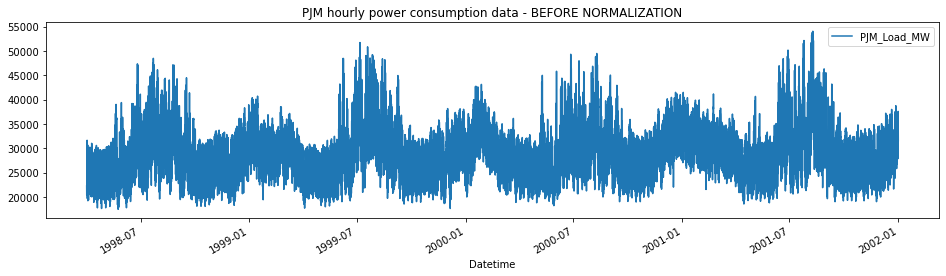

In [44]:
df.plot(figsize=(16,4),legend=True)

plt.title('PJM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

Verileri normalleştirmek için sklearn MinMaxScalar kullanacağız

In [45]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJM_Load_MW']=scaler.fit_transform(df['PJM_Load_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(32896, 1)

Normalleştirmeden sonra verileri görselleştirelim

* Normalleştirmeden sonra, grafiğin y ekseninde görebileceğimiz güç tüketimi değerleri aralığı değişir. Görüntülenen önceki grafikte 0 - 54000 aralığındaydı
* Normalleştirmeden sonra, y eksenindeki veri aralığının 0.0 - 1.0 olduğunu görebiliriz.

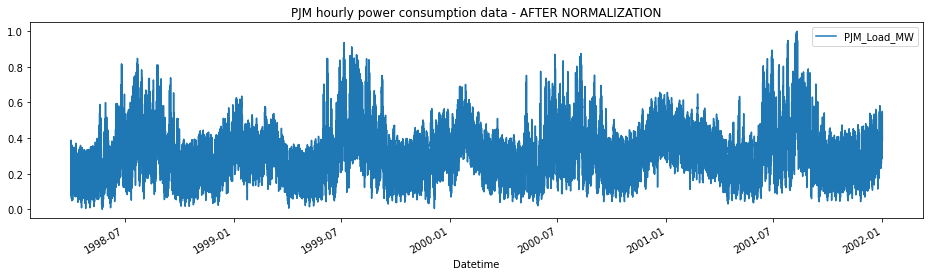

In [46]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('PJM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [47]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)-5):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i+5, 0])

    X_test = X_train[24114:]             
    y_test = y_train[24114:]
    
    X_train = X_train[:24114]           
    y_train = y_train[:24114]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (24114, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [48]:
print(df_norm.shape)

(32896, 1)


In [49]:
seq_len = 70 

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (24114, 70, 1)
y_train.shape =  (24114,)
X_test.shape =  (8707, 70, 1)
y_test.shape =  (8707,)


In [50]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator


Using TensorFlow backend.


RNN Modeli

In [51]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 70, 40)            1680      
_________________________________________________________________
dropout (Dropout)            (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 70, 40)            3240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 4

In [52]:
rnn_model.compile(optimizer="adam",loss="MSE")
history= rnn_model.fit(X_train, y_train, epochs=17, validation_data=(X_test, y_test), batch_size=1000)

Epoch 1/17
25/25 [==============================] - 6s 231ms/step - loss: 0.2717 - val_loss: 0.0312
Epoch 2/17
25/25 [==============================] - 5s 200ms/step - loss: 0.1263 - val_loss: 0.0108
Epoch 3/17
25/25 [==============================] - 5s 196ms/step - loss: 0.0808 - val_loss: 0.0070
Epoch 4/17
25/25 [==============================] - 5s 199ms/step - loss: 0.0550 - val_loss: 0.0059
Epoch 5/17
25/25 [==============================] - 5s 195ms/step - loss: 0.0390 - val_loss: 0.0067
Epoch 6/17
25/25 [==============================] - 5s 207ms/step - loss: 0.0307 - val_loss: 0.0060
Epoch 7/17
25/25 [==============================] - 5s 196ms/step - loss: 0.0257 - val_loss: 0.0053
Epoch 8/17
25/25 [==============================] - 5s 196ms/step - loss: 0.0224 - val_loss: 0.0050
Epoch 9/17
25/25 [==============================] - 5s 196ms/step - loss: 0.0196 - val_loss: 0.0056
Epoch 10/17
25/25 [==============================] - 5s 197ms/step - loss: 0.0177 - val_loss: 0.0056

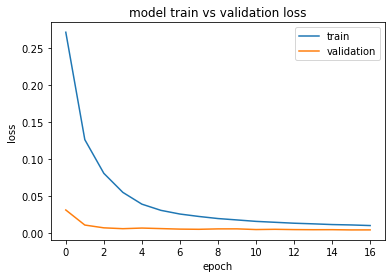

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Grafiğe göre, çağ sayısı arttıkça hem doğrulama kaybı hem de kaybı azalmaktadır.

In [54]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R^2 Score of RNN model = ",rnn_score)

R^2 Score of RNN model =  0.8368702493270719


Görünüşe göre RNN modeli XGBoost modelinden önemli ölçüde daha iyi bir iş çıkarıyor.

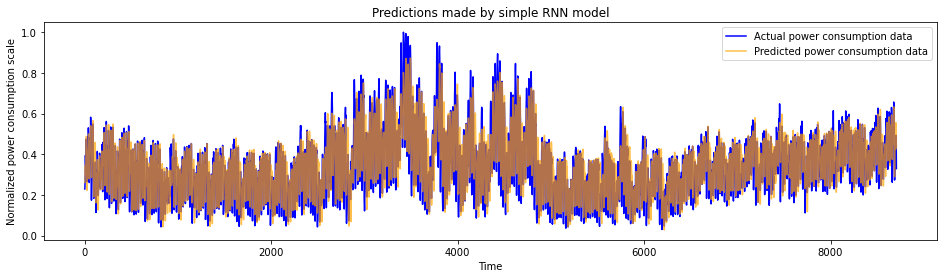

In [55]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# **LSTM Modeli**


In [56]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 40)            6720      
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 40)            12960     
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [57]:
lstm_model.compile(optimizer="adam",loss="MSE")
history_lstm=lstm_model.fit(X_train, y_train, epochs=28, validation_data=(X_test, y_test),batch_size=1000)


Epoch 1/28
25/25 [==============================] - 17s 689ms/step - loss: 0.0324 - val_loss: 0.0209
Epoch 2/28
25/25 [==============================] - 16s 643ms/step - loss: 0.0200 - val_loss: 0.0188
Epoch 3/28
25/25 [==============================] - 16s 631ms/step - loss: 0.0174 - val_loss: 0.0148
Epoch 4/28
25/25 [==============================] - 16s 637ms/step - loss: 0.0125 - val_loss: 0.0099
Epoch 5/28
25/25 [==============================] - 16s 630ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 6/28
25/25 [==============================] - 16s 645ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 7/28
25/25 [==============================] - 16s 633ms/step - loss: 0.0095 - val_loss: 0.0087
Epoch 8/28
25/25 [==============================] - 16s 655ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 9/28
25/25 [==============================] - 16s 642ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 10/28
25/25 [==============================] - 16s 643ms/step - loss: 0.0079 - val_lo

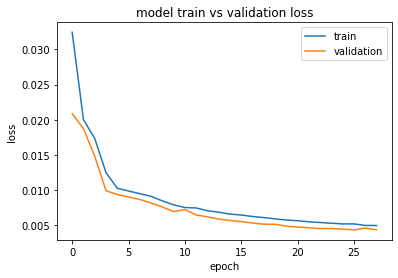

In [58]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [59]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.8312249685014776


Daha kolay referans: RNN modelinin R^2 puanı = 0,946558009942673. Bu nedenle, bu durumda LSTM modeli tahmin etmede daha iyidir.

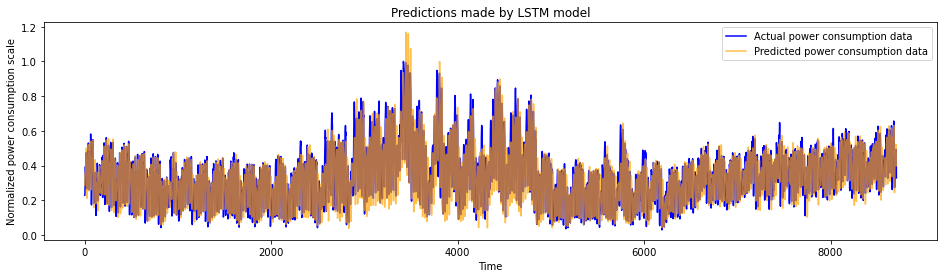

In [60]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

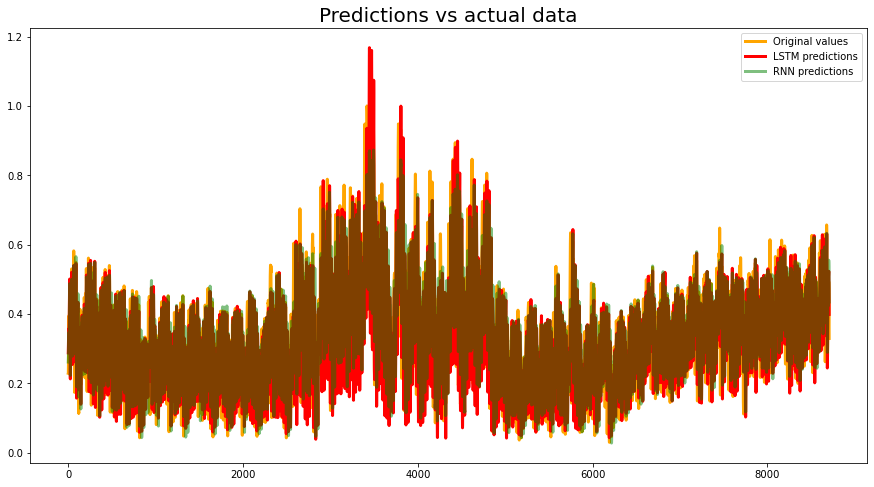

In [61]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

In [62]:
from scipy.stats import norm
from scipy import stats

In [63]:
sns.distplot(X_train['hour'], fit=norm);
fig = plt.figure()
res = stats.probplot(X_train['hour'], plot=plt)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

LSTM modeli oluşturma

In [64]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, y_train, epochs=50, batch_size=72, validation_data=(test_X, y_test), verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'train_X' is not defined

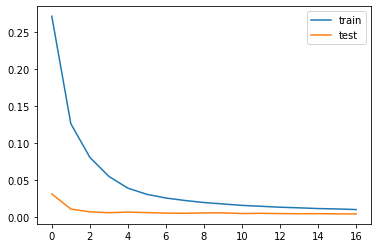

In [65]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()